In this project, I will be focussing on Baseball data analysis using some supervised learning methods. I will start with some data cleaning and imputing missing values. Then I will proceed to create some features that seem to have logical correlation with the number of WINS (which I will be predicting). After the data pre-processing, there will be the usual test-train split and I will be fitting some machine learning models to predict the number of wins. The metrics used to assess my model will be Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

In [ ]:
import pandas as pd
import sqlite3

**Importing the Lahman Database**


In [ ]:
!wget https://coatless.github.io/raw-data/lahman2019.sqlite

--2022-10-11 06:55:37--  https://coatless.github.io/raw-data/lahman2019.sqlite
Resolving coatless.github.io (coatless.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to coatless.github.io (coatless.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66019328 (63M) [application/octet-stream]
Saving to: ‘lahman2019.sqlite’

lahman2019.sqlite   100%[===================>]  62.96M   217MB/s    in 0.3s    

2022-10-11 06:55:38 (217 MB/s) - ‘lahman2019.sqlite’ saved [66019328/66019328]



In [ ]:
%load_ext sql
%sql sqlite:///lahman2019.sqlite

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


'Connected: @lahman2019.sqlite'

In [ ]:
%%sql 

SELECT * FROM teams NATURAL JOIN teamsFranchises 
            WHERE Teams.G >= 150 AND TeamsFranchises.active == 'Y';

In [ ]:
df = _.DataFrame()

In [ ]:
df.head()

**Cleaning and Pre-processing**

In [ ]:
# No. of records and features:

df.shape

(2376, 53)

In [ ]:
# Dropping columns which we will not be using:

cols_nreq = ['lgID','franchID','divID','teamRank','Ghome',
             'L','DivWin','WCWin','LgWin','WSWin','SF',
             'name','park','attendance','BPF','PPF',
             'teamIDBR','teamIDlahman45','teamIDretro',
             'franchID','franchName','active','NAassoc']
df = df.drop(cols_nreq, axis=1)

In [ ]:
df.shape

(2376, 31)

Check for missing values:

In [ ]:
list_null = df.isnull().sum(axis=0).tolist()

In [ ]:
df.columns
dict_null = {}

for i in range(len(df.columns)):
  dict_null[df.columns[i]] = list_null[i]

dict_null

{'ID': 0,
 'yearID': 0,
 'teamID': 0,
 'div_ID': 1050,
 'G': 0,
 'W': 0,
 'R': 0,
 'AB': 0,
 'H': 0,
 '2B': 0,
 '3B': 0,
 'HR': 0,
 'BB': 0,
 'SO': 16,
 'SB': 0,
 'CS': 418,
 'HBP': 943,
 'RA': 0,
 'ER': 0,
 'ERA': 0,
 'CG': 0,
 'SHO': 0,
 'SV': 0,
 'IPouts': 0,
 'HA': 0,
 'HRA': 0,
 'BBA': 0,
 'SOA': 0,
 'E': 0,
 'DP': 0,
 'FP': 0}

As we can observe, there are 16 null values in Strike-outs (SO), which is a significant variable to predict wins. So, we will be filling the missing values using the median of the data. The rest of the columns with null values can be dropped.

In [ ]:
df = df.drop(['div_ID', 'CS','HBP'],axis=1)


In [ ]:
df['SO'] = df['SO'].fillna(df['SO'].median())
df['DP'] = df['DP'].fillna(df['DP'].median())

Let's check the null values again.

In [ ]:
df.isnull().sum(axis=0).tolist()

**EDA and Data Visualization**

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

Plotting a histogram of wins:

Text(0.5, 1.0, 'Histogram of wins')

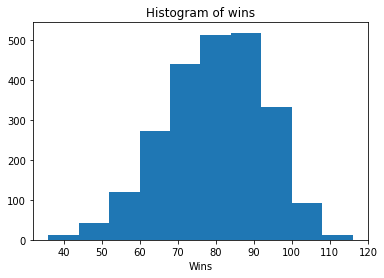

In [ ]:
plt.hist(df['W'])
plt.xlabel('Wins')
plt.title('Histogram of wins')

Summary stats:

In [ ]:
df['W'].mean()


79.28829966329967

Creating quartile bins for visualization:

In [ ]:
df['win_bins'] = pd.qcut(df.W, 4, labels = [1, 2, 3 ,4])

Visualizing wins over the years while also getting the frequency of wins in each win-bin:

Text(0, 0.5, 'Number of wins')

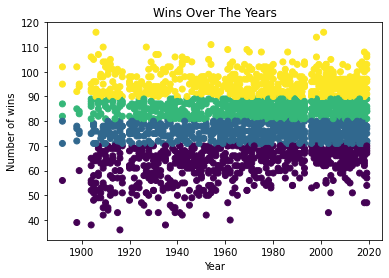

In [ ]:
plt.scatter(df['yearID'],df['W'],c=df['win_bins'])
plt.title('Wins Over The Years')
plt.xlabel('Year')
plt.ylabel('Number of wins')

The data is pretty sparse in years around and before 1900. We should drop these records.

In [ ]:
df = df[df['yearID']>1900]

Aggregating values on the basis of years.

In [ ]:
runs_per_year = df.groupby('yearID').sum()['R']


In [ ]:
games_per_year = df.groupby('yearID').sum()['G']

Calculating the average runs/games:

In [ ]:
avg_runs_per_game = runs_per_year/games_per_year

Visualizing the avg runs per game for different years.

Text(0, 0.5, 'MLB average runs per game')

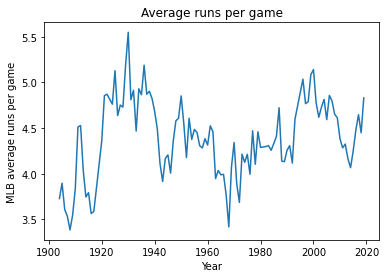

In [ ]:
plt.plot(avg_runs_per_game)
plt.title('Average runs per game')
plt.xlabel('Year')
plt.ylabel('MLB average runs per game')

**Feature Engineering**

Looking at the trend, we can conclude that the average runs per game varies with time. So, creating a time variable will be significant in modelling our data. If we look at the rough crests and troughs, we conclude that we have periods like 1920-1940, 1941-1945, 1946-1963, 1963-1978, 1979-1995, 1996-2010 and 2011-2020 with data roughly spread equally across a mean value. So, we will assign values on te basis of these time-periods.

In [ ]:
df['period_label'] = pd.cut(df["yearID"], [1900, 1920, 1941, 1945, 1963, 1978, 1995, 2010, 2020], labels = [1, 2, 3 ,4, 5, 6, 7, 8])

In [ ]:
df.isnull().sum(0)

Creating a period dummy variable:

In [ ]:
per_df = pd.get_dummies(df['period_label'],prefix='period')

In [ ]:
df.shape

(2355, 30)

In [ ]:
per_df

,period_1,period_2,period_3,period_4,period_5,period_6,period_7,period_8
0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
2371,0,0,0,0,0,0,0,1
2372,0,0,0,0,0,0,0,1
2373,0,0,0,0,0,0,0,1
2374,0,0,0,0,0,0,0,1


Concatenating the df with the dummy variables:

In [ ]:
df = pd.concat([df,per_df],axis=1)

In [ ]:
df.isnull().sum(0)

In [ ]:
df.head()

,ID,yearID,teamID,G,W,R,AB,H,2B,3B,...,IPouts,HA,HRA,BBA,SOA,E,DP,FP,win_bins,period_label
0,1368,1961,LAA,162,70,744,5424,1331,218,22,...,4314,1391,180,713,973,192,154,0.969,1,4
1,1387,1962,LAA,162,86,718,5499,1377,232,35,...,4398,1412,118,616,858,175,153,0.972,3,4
2,1407,1963,LAA,161,70,597,5506,1378,208,38,...,4365,1317,120,578,889,163,155,0.974,1,4
3,1427,1964,LAA,162,82,544,5362,1297,186,27,...,4350,1273,100,530,965,138,168,0.978,3,5
4,1440,1965,CAL,162,75,527,5354,1279,200,36,...,4323,1259,91,563,847,123,149,0.981,2,5


In [ ]:
mapping = avg_runs_per_game.to_dict()

In [ ]:
df["runs_per_game"] = df["yearID"].map(mapping)

We need to take into account of the most important statistics, i.e. how many runs are allowed and scored per match. Here, I have created two features.

In [ ]:
df["R_per_g"] = df['R']/df['G']
df["RA_per_g"] = df['RA']/df['G']

There should be pretty decent correlation between these variables and the likelihood of wins. Now, having the variables we need to check the correlation between each other.

In [ ]:
corr = df.corr()

corr.style.background_gradient(cmap='coolwarm')

,ID,yearID,G,W,R,AB,H,2B,3B,HR,BB,SO,SB,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,period_1,period_2,period_3,period_4,period_5,period_6,period_7,period_8,runs_per_game,R_per_g,RA_per_g
ID,1.000000,0.990916,0.793005,0.136830,0.277172,0.720694,0.205405,0.570170,-0.721103,0.767669,0.239352,0.881002,-0.088053,0.273783,0.507649,0.401806,-0.925537,-0.200957,0.823332,0.705582,0.200373,0.828429,0.240219,0.881479,-0.815482,0.280965,0.824053,-0.526001,-0.450318,-0.137212,-0.222017,-0.056941,0.165634,0.499123,0.550444,0.234376,0.148541,0.146634
yearID,0.990916,1.000000,0.818208,0.142396,0.271254,0.749241,0.207579,0.543879,-0.754256,0.786748,0.275942,0.866747,-0.126467,0.267601,0.514981,0.405614,-0.939864,-0.203476,0.845376,0.736075,0.202398,0.848774,0.276580,0.868702,-0.848657,0.336061,0.856587,-0.592072,-0.474574,-0.131085,-0.175028,0.015621,0.209347,0.477241,0.484066,0.218950,0.139011,0.136918
G,0.793005,0.818208,1.000000,0.177112,0.151301,0.754747,0.132779,0.332103,-0.629687,0.610465,0.194448,0.769293,0.100003,0.128615,0.316897,0.178417,-0.754928,-0.059760,0.765399,0.922594,0.117210,0.655741,0.182701,0.772854,-0.617908,0.202196,0.654643,-0.359090,-0.544008,-0.208839,-0.321195,0.254378,0.319054,0.367433,0.276614,-0.028009,-0.010588,-0.031003
W,0.136830,0.142396,0.177112,1.000000,0.557075,0.232788,0.380450,0.266702,0.009280,0.312399,0.355605,0.071163,0.129548,-0.523198,-0.377948,-0.431197,-0.045477,0.430544,0.385457,0.326200,-0.397713,0.005783,-0.289600,0.255823,-0.299166,0.005030,0.313747,-0.078930,-0.080990,-0.033177,-0.048162,0.042054,0.052918,0.061930,0.046996,0.009658,0.535288,-0.555982
R,0.277172,0.271254,0.151301,0.557075,1.000000,0.526534,0.829738,0.699329,-0.004618,0.577271,0.551640,0.127324,-0.086219,0.331820,0.409800,0.391434,-0.267527,-0.236968,0.316684,0.137186,0.350930,0.388375,0.155441,0.199568,-0.350696,0.265864,0.339004,-0.343997,0.194471,-0.110440,-0.057058,-0.202572,-0.000339,0.341381,0.033441,0.622571,0.986535,0.309250
AB,0.720694,0.749241,0.754747,0.232788,0.526534,1.000000,0.637257,0.650918,-0.481391,0.692632,0.241822,0.566985,-0.182794,0.375602,0.561298,0.454496,-0.721650,-0.274229,0.668746,0.746483,0.429107,0.700294,0.258710,0.602251,-0.678697,0.410964,0.694851,-0.624466,-0.164465,-0.114372,-0.244177,0.105252,0.233602,0.391993,0.218070,0.364774,0.410198,0.258947
H,0.205405,0.207579,0.132779,0.380450,0.829738,0.637257,1.000000,0.710355,0.088469,0.359533,0.237687,-0.040173,-0.127701,0.382380,0.438389,0.423813,-0.228559,-0.286529,0.231399,0.131086,0.506781,0.276451,0.106112,0.061162,-0.290396,0.322574,0.284320,-0.402843,0.336772,-0.080812,-0.152534,-0.151984,0.068415,0.289479,-0.051817,0.624178,0.818970,0.365482
2B,0.570170,0.543879,0.332103,0.266702,0.699329,0.650918,0.710355,1.000000,-0.231146,0.536878,0.292967,0.360747,-0.158783,0.435054,0.556859,0.518842,-0.540324,-0.310568,0.449767,0.276990,0.463115,0.514511,0.178147,0.406013,-0.525199,0.280753,0.516015,-0.467276,0.152818,-0.093922,-0.240541,-0.285781,0.026646,0.504413,0.239729,0.631679,0.652552,0.384876
3B,-0.721103,-0.754256,-0.629687,0.009280,-0.004618,-0.481391,0.088469,-0.231146,1.000000,-0.645240,-0.246311,-0.663870,0.239563,-0.153310,-0.352038,-0.268621,0.704237,0.105824,-0.628636,-0.565129,-0.070358,-0.673730,-0.267170,-0.656115,0.655150,-0.269097,-0.660804,0.481788,0.490193,0.029878,0.017522,-0.133756,-0.174456,-0.322429,-0.280662,-0.009500,0.101761,-0.052658
HR,0.767669,0.786748,0.610465,0.312399,0.577271,0.692632,0.359533,0.536878,-0.645240,1.000000,0.426638,0.715255,-0.290087,0.316583,0.526406,0.445903,-0.750328,-0.243254,0.713442,0.546929,0.217748,0.844224,0.290418,0.713087,-0.746630,0.358288,0.742536,-0.572248,-0.319745,-0.166747,0.026690,-0.002946,0.077989,0.427379,0.335116,0.365466,0.481099,0.219194


As we can see the variables W is having a correlation of 0.53 with R_per_g and -0.55 with RA_per_g which is expected.

**Model-fitting**

In [ ]:
# Extracting numeric columns:

numeric_cols = ['G', 'W', 'R', 'AB', 'H', '2B', '3B', 'HR',
       'BB', 'SO', 'SB', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA',
       'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'win_bins', 'period_label',
       'period_1', 'period_2', 'period_3', 'period_4', 'period_5', 'period_6',
       'period_7', 'period_8', 'runs_per_game', 'R_per_g', 'RA_per_g']

In [ ]:
df = df[numeric_cols]

Train-test split:

In [ ]:
train = df.sample(frac = 0.8, random_state=1)
test = df.loc[~df.index.isin(train.index)]

In [ ]:
x_var = ['G', 'R', 'AB', 'H', '2B', '3B', 'HR',
       'BB', 'SO', 'SB', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA',
       'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'win_bins', 'period_label',
       'period_1', 'period_2', 'period_3', 'period_4', 'period_5', 'period_6',
       'period_7', 'period_8', 'runs_per_game', 'R_per_g', 'RA_per_g']

In [ ]:
x_train = train[x_var]
y_train = train['W']
x_test = test[x_var]
y_test = test['W']

Here, I am choosing Mean Absolute Error as the metric to judge our model.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math

In [ ]:
x_train

,G,R,AB,H,2B,3B,HR,BB,SO,SB,...,period_2,period_3,period_4,period_5,period_6,period_7,period_8,runs_per_game,R_per_g,RA_per_g
1697,152,607,5261,1439,240,41,60,381,479.0,55,...,1,0,0,0,0,0,0,4.467217,3.993421,5.000000
65,162,712,5398,1350,286,40,171,532,1111.0,109,...,0,0,0,0,0,1,0,4.796791,4.395062,4.518519
1879,162,680,5573,1445,292,38,139,471,1092.0,73,...,0,0,0,0,0,1,0,4.591732,4.197531,4.746914
489,162,614,5619,1411,251,35,107,471,912.0,93,...,0,0,0,0,1,0,0,4.288124,3.790123,4.493827
581,162,683,5508,1379,208,40,114,571,896.0,64,...,0,0,1,0,0,0,0,3.946881,4.216049,3.358025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,162,609,5510,1361,227,26,97,456,1005.0,137,...,0,0,0,0,1,0,0,4.297579,3.759259,4.462963
911,155,722,5502,1479,283,78,57,475,523.0,68,...,1,0,0,0,0,0,0,4.467217,4.658065,4.729032
2140,156,780,5422,1462,235,65,115,612,511.0,28,...,0,0,1,0,0,0,0,4.355189,5.000000,4.064103
71,162,685,5676,1468,302,31,130,519,1142.0,62,...,0,0,0,0,0,0,1,4.165981,4.228395,4.290123


Linear Regression

In [ ]:
lm = LinearRegression(normalize=True)
lm.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


LinearRegression(normalize=True)

Prediction:

In [ ]:
pred = lm.predict(x_test)

Model metrics:

In [ ]:
mae = mean_absolute_error(y_test,pred)
rmse = math.sqrt(mean_squared_error(y_test,pred)) 

In [ ]:
mae, rmse

(2.257912022292994, 2.8647830419793503)

As we can see, the Mean Absolute Error in predicting the number of wins is 2.25. When we compare it with the average number of wins, i.e. 79, it gives us an error of around 2.8% which is pretty good.

Ridge Regression

In [ ]:
from sklearn.linear_model import RidgeCV

In [ ]:
ridge = RidgeCV(alphas=(0.01,0.1,1,10),normalize=True)

In [ ]:
ridge.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


RidgeCV(alphas=array([ 0.01,  0.1 ,  1.  , 10.  ]), normalize=True)

Prediction

In [ ]:
pred_ridge = ridge.predict(x_test)

Model metrics:

In [ ]:
mae_ridge = mean_absolute_error(y_test,pred_ridge)
rmse_ridge = math.sqrt(mean_squared_error(y_test,pred_ridge)) 

In [ ]:
mae_ridge, rmse_ridge

(2.247575057486628, 2.8423850713147067)

The Ridge regression model gives slightly better accuracy than Linear regression which might be due to fact that there is correlation in the data as observed from the correlation matrix above.

**Conclusion**

This was an attempt to analyze Baseball data to predict the number of wins by using the variables that we have in the famous Lahman Database. In this project, I have performed data cleaning, EDA, feature engineering, model fitting and model analysis (using MAE and RMSE) to get insight from the Baseball data.